```{index} disjunctive programming
```
```{index} single: solver; cbc
```
```{index} single: application; maintenance planning
```

# Extra material: Maintenance planning

## Problem statement


A process unit is operating over a maintenance planning horizon from $1$ to $T$ days.  On day $t$ the unit makes a profit $c[t]$ which is known in advance. The unit needs to shut down for $P$ maintenance periods during the planning period.  Once started, a maintenance period takes $M$ days to finish.

Find a maintenance schedule that allows the maximum profit to be produced.

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and HiGHS, then sets SOLVER to 
use the Highs solver via the appsi module. If run elsewhere, it assumes Pyomo and CBC
have been previously installed and sets SOLVER to use the CBC solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [1]:
import sys

if 'google.colab' in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null

    from pyomo.contrib import appsi
    SOLVER = appsi.solvers.Highs(only_child_vars=False)
    
else:
    from pyomo.environ import SolverFactory
    SOLVER = SolverFactory('cbc')

assert SOLVER.available(), f"Solver {SOLVER} is not available."

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import pyomo.gdp as gdp

## Modeling with disjunctive constraints

The model is comprised of two sets of the binary variables indexed 1 to $T$. Binary variables $x_t$ correspond to the operating mode of the process unit, with $x_t=1$ indicating the unit is operating on day $t$ and able to earn a profit $c_t$. Binary variable $y_t=1$ indicates the first day of a maintenance period during which the unit is not operating and earning $0$ profit.

### Objective

The planning objective is to maximize profit realized during the days the plant is operational. 

$$
\begin{align*}
\mbox{Profit} & = \max_{x, y} \sum_{t=1}^T c_t x_t
\end{align*}
$$

subject to completing $P$ maintenance periods.  

### Constraints

**Number of maintenance periods is equal to P.**

Completing $P$ maintenance periods requires a total of $P$ starts.

$$
\begin{align*}
\sum_{t=1}^T y_t &  = P \\
\end{align*}
$$

**Maintenance periods do not overlap.**

No more than one maintenance period can start in any consecutive set of M days.

$$
\begin{align*}
\sum_{s=0}^{M-1}y_{t+s} & \leq 1 \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

This last requirement could be modified if some period of time should occur between maintenance periods.

**The unit must shut down for M days following a maintenance start.**

The final requirement is a disjunctive constraint that says either $y_t = 0$ or the sum $\sum_{s}^{M-1}x_{t+s} = 0$, but not both. Mathematically, this forms a set of constraints reading

$$
\begin{align*}
\left(y_t = 0\right) \veebar \left(\sum_{s=0}^{M-1}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

where $\veebar$ denotes an exclusive or condition.

## Pyomo solution

### Parameter values

In [3]:
# problem parameters
T = 90        # planning period from 1..T
M = 3         # length of maintenance period
P = 4         # number of maintenance periods

# daily profits
c = {k: np.random.uniform() for k in range(1, T+1)}

### Pyomo model

The disjunctive constraints can be represented directly in Pyomo using the [Generalized Disjunctive Programming](https://pyomo.readthedocs.io/en/latest/modeling_extensions/gdp.html) extension. The GDP extension transforms the disjunctive constraints to a mixed integer linear optimization (MILO) problem using convex hull and cutting plane methods.

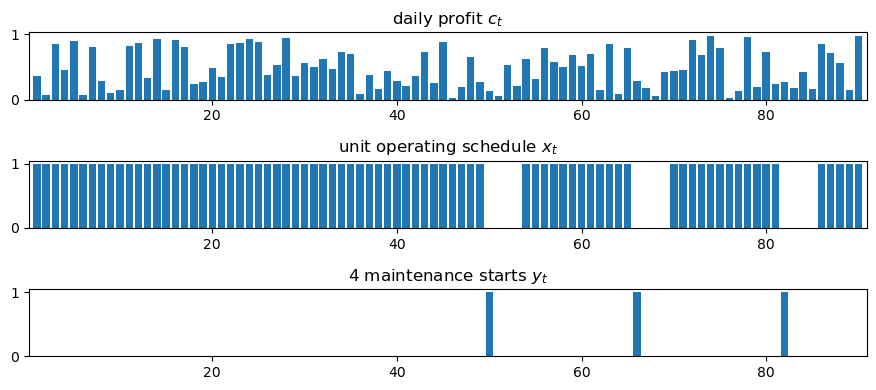

In [4]:
def maintenance_planning(c, M, P):
    m = pyo.ConcreteModel()

    T = len(c)
    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T - M + 1)
    m.S = pyo.RangeSet(0, M - 1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.T, domain=pyo.Binary)

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return sum(m.c[t]*m.x[t] for t in m.T)

    @m.Constraint()
    def required_maintenance(m):
        return P == sum(m.y[t] for t in m.Y)
    
    @m.Constraint(m.Y)
    def no_overlap(m, t):
        return sum(m.y[t+s] for s in m.S) <= 1
    
    @m.Disjunction(m.Y, xor=True)
    def required_shutdown(m, t):
        return [[m.y[t]==0], [sum(m.x[t+s] for s in m.S) == 0]]

    pyo.TransformationFactory("gdp.hull").apply_to(m)
    
    return m

def plot_schedule(m):
    fig,ax = plt.subplots(3, 1, figsize=(9,4))
    
    ax[0].bar(m.T, [m.c[t] for t in m.T])
    ax[0].set_title('daily profit $c_t$')
    
    ax[1].bar(m.T, [m.x[t]() for t in m.T], label='normal operation')
    ax[1].set_title('unit operating schedule $x_t$')
    
    ax[2].bar(m.Y, [m.y[t]() for t in m.Y])
    ax[2].set_title(str(P) + ' maintenance starts $y_t$')
    for a in ax:
        a.set_xlim(0.1, len(m.T)+0.9)
        
    plt.tight_layout()

model = maintenance_planning(c, 4, 3)
SOLVER.solve(model)
plot_schedule(model)

## Ramping constraints

Prior to maintenance shutdown, a large processing unit may take some time to safely ramp down from full production. And then require more time to safely ramp back up to full production following maintenance. To provide for ramp-down and ramp-up periods, we modify the problem formation in the following ways.

* The variable denoting unit operation, $x_t$ is changed from a binary variable to a continuous variable $0 \leq x_t \leq 1$ denoting the fraction of total capacity at which the unit is operating on day $t$.

* Two new variable sequences, $0 \leq u_t^+ \leq u_t^{+,\max}$ and $0\leq u_t^- \leq u_t^{-,\max}$, are introduced which denote the fraction increase or decrease in unit capacity to completed on day $t$.

* An additional sequence of equality constraints is introduced relating $x_t$ to $u_t^+$ and $u_t^-$.

$$
\begin{align*}
x_{t} & = x_{t-1} + u^+_t - u^-_t
\end{align*}
$$

We begin the Pyomo model by specifying the constraints, then modifying the Big-M formulation to add the features described above.

In [5]:
upos_max = 0.3334
uneg_max = 0.5000

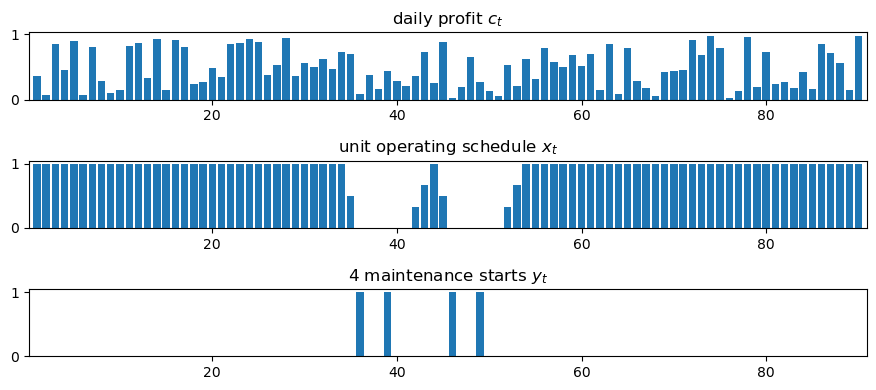

In [6]:
def maintenance_planning_ramp(c, M, P):
    m = pyo.ConcreteModel()

    T = len(c)
    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T - M + 1)
    m.S = pyo.RangeSet(0, M - 1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, bounds=(0, 1))
    m.y = pyo.Var(m.T, domain=pyo.Binary)
    m.upos = pyo.Var(m.T, bounds=(0, upos_max))
    m.uneg = pyo.Var(m.T, bounds=(0, uneg_max))
    
    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return sum(m.c[t]*m.x[t] for t in m.T)

    @m.Constraint()
    def required_maintenance(m):
        return P == sum(m.y[t] for t in m.Y)
    
    @m.Constraint(m.Y)
    def no_overlap(m, t):
        return sum(m.y[t+s] for s in m.S) <= 1
    
    @m.Disjunction(m.Y, xor=True)
    def required_shutdown(m, t):
        return [[m.y[t]==0], [sum(m.x[t+s] for s in m.S) == 0]]
    
    @m.Constraint(m.T)
    def ramp(m, t):
        if t == 1:
            return pyo.Constraint.Skip
        else:
            return m.x[t] == m.x[t-1] + m.upos[t] - m.uneg[t]

    pyo.TransformationFactory("gdp.hull").apply_to(m)
    
    return m
  
m = maintenance_planning_ramp(c, M, P)
SOLVER.solve(m)
plot_schedule(m)

## Specifying the minimum number of operational days between maintenance periods

Up to this point we have imposed no constraints on the frequency of maintenance periods. Without such constraints, particularly when ramping constraints are imposed, is that maintenance periods will be scheduled back-to-back, which is clearly not a useful result for most situations.

The next revision of the model is to incorporate a requirement that $N$ operational days be scheduled between any maintenance periods. This does allow for maintenance to be postponed until the very end of the planning period. The disjunctive constraints read

$$
\begin{align*}
\left(y_t = 0\right) \veebar \left(\sum_{s=0}^{(M + N -1) \wedge (t + s \leq T)}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

where the upper bound on the summation is needed to handle the terminal condition. 

Paradoxically, this is an example where the Big-M method provides a much faster solution.

$$
\begin{align*}
\sum_{s=0}^{(M + N -1) \wedge (t + s \leq T)}x_{t+s} \leq (M+N)(1-y_t) \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

The following cell implements both sets of constraints. 

In [7]:
N = 10  # minimum number of operational days between maintenance periods

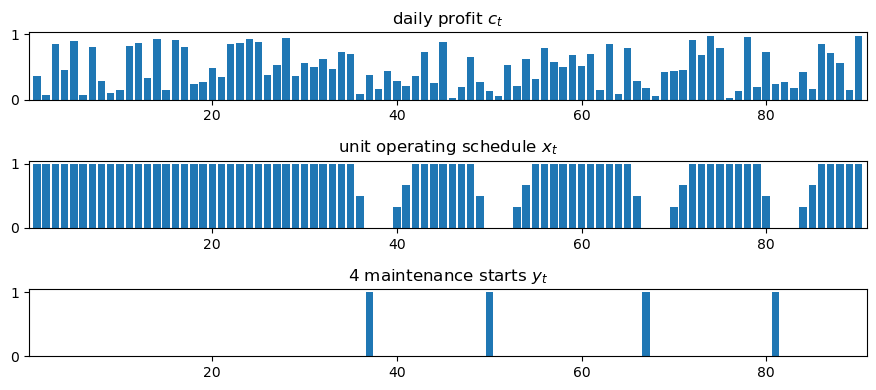

In [8]:
def maintenance_planning_ramp_operational(c, T, M, P, N):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T - M + 1)
    m.S = pyo.RangeSet(0, M - 1)
    m.W = pyo.RangeSet(0, M + N - 1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, bounds=(0, 1))
    m.y = pyo.Var(m.T, domain=pyo.Binary)
    m.upos = pyo.Var(m.T, bounds=(0, upos_max))
    m.uneg = pyo.Var(m.T, bounds=(0, uneg_max))

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return sum(m.c[t]*m.x[t] for t in m.T)
    
    # ramp constraint
    @m.Constraint(m.T)
    def ramp(m, t):
        if t > 1:
            return m.x[t] == m.x[t-1] + m.upos[t] - m.uneg[t]
        return pyo.Constraint.Skip
      
    # required number P of maintenance starts
    @m.Constraint()
    def sumy(m):
        return sum(m.y[t] for t in m.Y) == P

    # no more than one maintenance start in the period of length M
    @m.Constraint(m.Y)
    def sprd(m, t):
        return sum(m.y[t+s] for s in m.W if t + s <= T) <= 1

    # Choose one or the other the following methods. Comment out the method not used.

    #@m.Disjunction(m.Y)
    #def disj(m, t):
    #    return [m.y[t] == 0, 
    #            sum(m.x[t+s] for s in m.W if t + s <= T) == 0]
    #pyo.TransformationFactory('gdp.bigm').apply_to(m)
    
    # disjunctive constraints, big-M method.
    @m.Constraint(m.Y)
    def bigm(m, t):
        return sum(m.x[t+s] for s in m.S) <= (M+N)*(1 - m.y[t])
    
    return m

m = maintenance_planning_ramp_operational(c, T, M, P, N)
SOLVER.solve(m)
plot_schedule(m)

## Exercises

1. Rather than specify how many maintenance periods must be accommodated, modify the model so that the process unit can operate no more than $N$ days without a maintenance shutdown.  (Hint. You may to introduce an additional set of binary variables, $z_t$ to denote the start of an operational period.)

2. Do a systematic comparison of the Big-M, Convex Hull, and Cutting Plane techniques for implementing the disjunctive constraints. Your comparison should include a measure of complexity (such as the number of decision variables and constraints in the resulting transformed problems), computational effort, and the effect of solver (such as HiGHS vs cbc).